# Load packages

In [14]:
# --- Standard library ---
import os
import sys
import xml.etree.ElementTree as ET
from xml.dom import minidom

# --- Third-party libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tifffile as tf
from tqdm import tqdm
from skimage.registration import phase_cross_correlation
from skimage.transform import PiecewiseAffineTransform, warp
from scipy.ndimage import fourier_shift, shift
from scipy.interpolate import Rbf
from sklearn.neighbors import NearestNeighbors

# --- Add src folder to sys.path ---
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../src/"))
sys.path.append(parent_dir)

# --- Custom modules ---
from plotting import *
from reading import *
from processing import *
from image_transform import *
from image_register import *
from feature_detector import *


# Process images

In [4]:
base_path = '/media/sergio/Meninges/dvp_alignment/roi_whole_slide'

############ CHUNK FOR LOADING ######################################

# Load Round 0 channels
img1_ch1, img1_ch2, img1_ch3 = load_round_channels(base_path, round_number=0)

# Load Round 1 channels
img2_ch1, img2_ch2, img2_ch3 = load_round_channels(base_path, round_number=1)


In [5]:
############### CHUNK FOR TRANSFORMING IMAGES TO DOWNSCALED #####################

# merge into a grayscale rgb
img1_roi = merge_channels_to_rgb([normalize_uint16_to_uint8(img1_ch1), normalize_uint16_to_uint8(img1_ch2),normalize_uint16_to_uint8(img1_ch3)])
img2_roi = merge_channels_to_rgb([normalize_uint16_to_uint8(img2_ch1), normalize_uint16_to_uint8(img2_ch2), normalize_uint16_to_uint8(img2_ch3)])

# --- CLAHE on each channel ---
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
img1_enh = cv2.merge([clahe.apply(c) for c in cv2.split(img1_roi)])
img2_enh = cv2.merge([clahe.apply(c) for c in cv2.split(img2_roi)])

# --- Downsample ---
scale = 0.01
img1_down = cv2.resize(img1_enh, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
img2_down = cv2.resize(img2_enh, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)


del img1_ch2
del img1_ch3
del img2_ch1
del img2_ch2
del img2_ch3

In [6]:
############### CHUNK FOR REGISTERING #####################

# Fint match_orb features
H, good_matches, pts1, pts2, kp1, kp2 = orb_feature_matching(img1_down, img2_down)

# Compute H (transformation) and apply it
H, img2_aligned, inlier_matches = compute_homography_and_warp(img1_down, img2_down, src_pts, dst_pts, good_matches, ransac_thresh=3.0)

# plot the identified ORB features
plot_inlier_matches(img1_down, img2_down, kp1, kp2, inlier_matches, title="Inlier ORB Matches")

# we also adjust H to the full resolution image
H_fullres=adjust_homography_scale(H, scale)



NameError: name 'orb_feature_matching' is not defined

In [16]:
H_fullres

array([[ 1.00349662e+00, -3.09417914e-03,  7.40461155e+02],
       [ 1.18465845e-02,  9.95388019e-01,  2.07257879e+03],
       [ 7.81377845e-07, -9.54765412e-08,  1.00000000e+00]])

# Per tile, extract features and store

In [ ]:
pts1_all, pts2_all = extract_matches_over_image(
    img1_enh=img1_enh,
    img2_enh=img2_enh,
    img1_chs=[img1_ch1, img1_ch2, img1_ch3],
    img2_chs=[img2_ch1, img2_ch2, img2_ch3],
    H_fullres=H_fullres,
    tile_size=5000, #8000 originally
    stride=5000, #8000 originally # 50% overlap
    n_neighbors=5,error_threshold=50.0,feature_detector='akaze')

In [43]:
    # Step 3: Combine and filter globally
pts1_all = np.float32(pts1_all)
pts2_all = np.float32(pts2_all)
print(f"Total combined matches before global consistency check: {len(pts1_all)}")

# Filter for consistency 
consistency_flags = check_local_consistency(pts1_all, pts2_all, n_neighbors=5, error_threshold=50.0)
pts1_consistent = pts1_all[consistency_flags]
pts2_consistent = pts2_all[consistency_flags]
print(f"After global consistency filtering: {len(pts1_consistent)} matches retained")

#
img2_gray = cv2.cvtColor(img2_enh, cv2.COLOR_BGR2GRAY)
img1_gray = cv2.cvtColor(img1_enh, cv2.COLOR_BGR2GRAY)

Total combined matches before global consistency check: 302
After global consistency filtering: 302 matches retained


# Apply the registration on downscaled images

In [47]:
# --- Downsample ---
scale = 0.1
img1_red = cv2.resize(img1_enh, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
img2_red = cv2.resize(img2_enh, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)


img1_red = cv2.cvtColor(img1_red, cv2.COLOR_BGR2GRAY)
img2_red = cv2.cvtColor(img2_red, cv2.COLOR_BGR2GRAY)

pts1_scaled=pts1_consistent*scale
pts2_scaled=pts2_consistent*scale

warped = piecewise_affine_warp(pts1_scaled, pts2_scaled, img2_red)


# Visualize output

In [ ]:
plot_overlay(img1_red, warped, pts=pts1_scaled, figsize=(25, 25))

In [ ]:
plot_point_mappings(
    pts1_consistent, pts2_consistent,
    background_img1=img1_gray,
    background_img2=img2_gray,
    alpha1=0.6, alpha2=0.4,
    title="Mapping between pts1 and pts2 on overlapping backgrounds"
)


# Deprectated code

In [140]:
roi = (30000, 10000, 5000, 5000)

In [141]:
pts1_consistent_rev = pts1_consistent[:, ::-1]
pts2_consistent_rev = pts2_consistent[:, ::-1]


In [142]:
import numpy as np
import cv2
from scipy.spatial import Delaunay
from scipy.ndimage import map_coordinates

# Assume these are defined somewhere before:
# pts1_consistent: (N, 2) array of matched points in img1 (x, y)
# pts2_consistent: (N, 2) array of matched points in img2 (x, y)
# img2_gray: source grayscale image (img2) as a 2D numpy array
# roi = (x, y, w, h) in img1 coordinate system

x, y, w, h = roi

# 1. Delaunay triangulation on pts1
tri = Delaunay(pts1_consistent_rev)

# 2. Meshgrid of all pixel coords in ROI
xv, yv = np.meshgrid(np.arange(x, x + w), np.arange(y, y + h))
coords = np.stack([xv.ravel(), yv.ravel()], axis=-1).astype(np.float32)  # (num_pixels, 2)



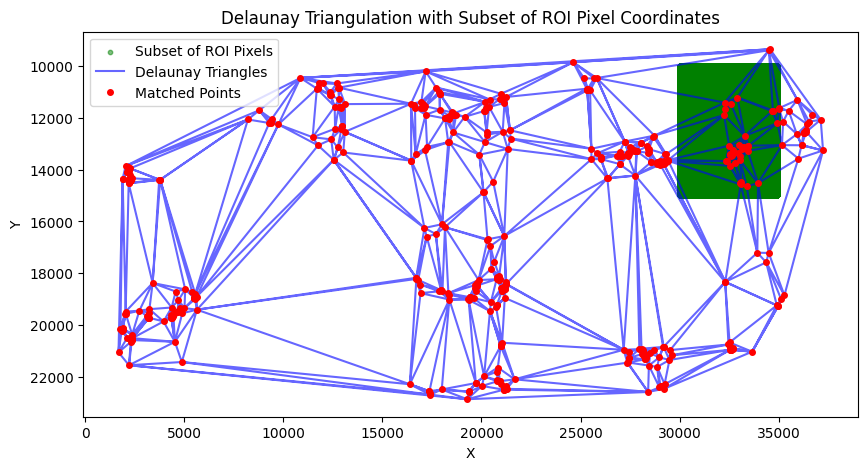

In [144]:
subset_coords = coords[::100]  # Take every 100th point
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.scatter(subset_coords[:, 0], subset_coords[:, 1], s=10, color='green', alpha=0.5, label='Subset of ROI Pixels')
plt.triplot(pts1_consistent_rev[:, 0], pts1_consistent_rev[:, 1], tri.simplices.copy(), color='blue', alpha=0.6, label='Delaunay Triangles')
plt.plot(pts1_consistent_rev[:, 0], pts1_consistent_rev[:, 1], 'o', color='red', markersize=4, label='Matched Points')

plt.gca().invert_yaxis()
plt.title('Delaunay Triangulation with Subset of ROI Pixel Coordinates')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [159]:
# 3. Find which triangle each pixel belongs to (-1 if outside)
simplex_indices = tri.find_simplex(coords)

# 4. Prepare output image patch
warped_roi = np.zeros((w, h), dtype=img2_gray.dtype)

# 5. Loop over all triangles that have pixels inside
for tri_idx in np.unique(simplex_indices):
    if tri_idx == -1:
        continue  # skip pixels outside

    # Mask for pixels inside this triangle
    mask = simplex_indices == tri_idx
    coords_in_tri = coords[mask]

    # Triangle corners in pts1 and pts2
    tri_pts1 = pts1_consistent[tri.simplices[tri_idx]]
    tri_pts2 = pts2_consistent[tri.simplices[tri_idx]]

    # Check triangle area to avoid degenerate transforms
    area = 0.5 * abs(
        tri_pts1[0,0]*(tri_pts1[1,1]-tri_pts1[2,1]) +
        tri_pts1[1,0]*(tri_pts1[2,1]-tri_pts1[0,1]) +
        tri_pts1[2,0]*(tri_pts1[0,1]-tri_pts1[1,1])
    )
    if area < 1.0:
        continue

    # Get affine transform from pts1 to pts2
    A = cv2.getAffineTransform(tri_pts1.astype(np.float32), tri_pts2.astype(np.float32))

    # Prepare homogeneous coords (x,y,1)
    coords_h = np.hstack([coords_in_tri, np.ones((coords_in_tri.shape[0], 1), dtype=np.float32)])

    # Apply affine transform (to img2 coords)
    mapped = (A @ coords_h.T).T  # (N, 2) in (x,y) format

    # Prepare coords for interpolation (y, x) order
    mapped_coords = np.stack([mapped[:,1], mapped[:,0]], axis=0)

    # Sample pixels from img2_gray
    sampled_vals = map_coordinates(img2_gray.transpose(), mapped_coords, order=1, mode='reflect')

    # Calculate output pixel indices relative to ROI (0-based)
    out_x = (coords_in_tri[:, 0] - x).astype(int)
    out_y = (coords_in_tri[:, 1] - y).astype(int)

    # Fill output patch
    warped_roi[out_y, out_x] = sampled_vals.astype(img2_gray.dtype)

# Now warped_roi contains the warped ROI patch of img2_gray into img1 coords


In [160]:
roi_warped=warped_roi

In [161]:
roi_1=img1_gray[roi[1]:roi[1]+roi[3],roi[0]:roi[0]+roi[2]]

In [162]:
plot_overlay(roi_1, roi_warped, figsize=(20, 20))

ValueError: could not broadcast input array from shape (5000,5000) into shape (5000,0)

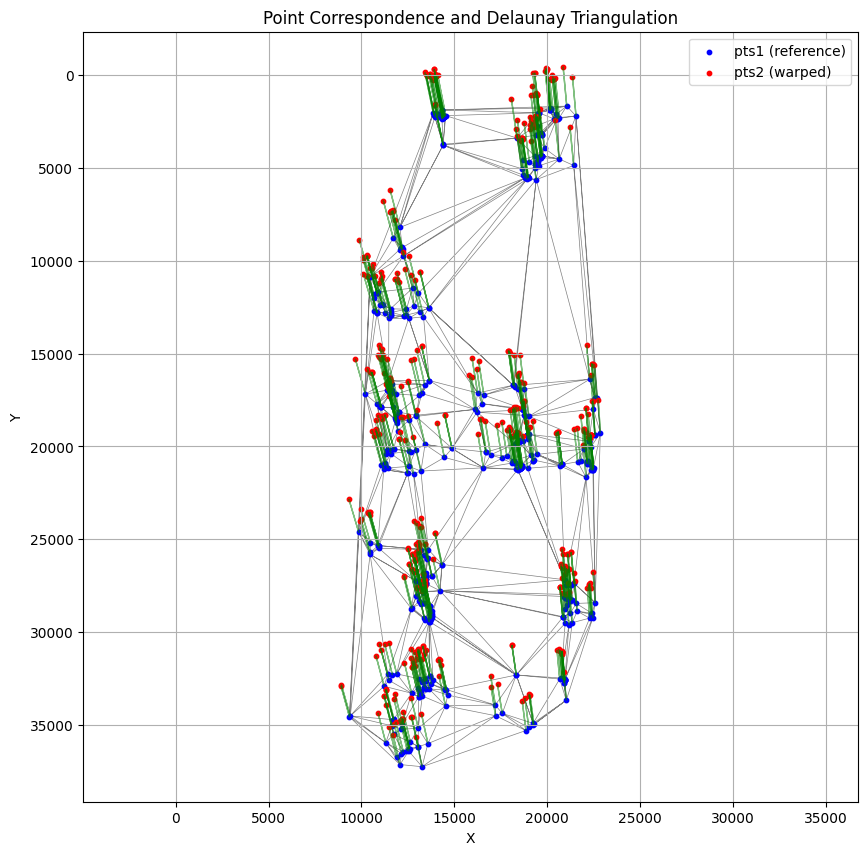

In [84]:
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

def plot_correspondence_with_triangulation(pts1, pts2):
    pts1 = np.asarray(pts1)
    pts2 = np.asarray(pts2)

    # Create Delaunay triangulation on pts1
    tri = Delaunay(pts1)

    plt.figure(figsize=(10, 10))
    
    # Plot triangulation
    plt.triplot(pts1[:, 0], pts1[:, 1], tri.simplices, color='gray', linewidth=0.5)
    
    # Plot original points
    plt.scatter(pts1[:, 0], pts1[:, 1], c='blue', label='pts1 (reference)', s=10)
    plt.scatter(pts2[:, 0], pts2[:, 1], c='red', label='pts2 (warped)', s=10)

    # Draw arrows between corresponding points
    for p1, p2 in zip(pts1, pts2):
        plt.arrow(p1[0], p1[1], p2[0] - p1[0], p2[1] - p1[1],
                  color='green', alpha=0.5, head_width=5, length_includes_head=True)

    plt.gca().invert_yaxis()  # Optional for image-style coordinate systems
    plt.legend()
    plt.title("Point Correspondence and Delaunay Triangulation")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# Usage:
plot_correspondence_with_triangulation(pts1_consistent, pts2_consistent)
